<a href="https://colab.research.google.com/github/kiyong21c/kaggle/blob/main/20220613_porto-seguro-safe-driver-prediction-visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 안전 운전자 예측
 - 실제 보험사에서 제공한 고객 데이터 활용하여 운전자가 보험을 청구할 확률 예측
 - 문제유형 : 이진분류
 - 평가지표 : 정규화된 지니계수
 - 사용모델 : LightGBM, XGBoost의 앙상블

 - 결측값이(-1로 표기) 많음
 - 0:보험금 미청구, 1:보험금 청구

 - 학습 순서
  > 1.탐색적 데이터 분석

  > 2.베이스라인 모델(LightGBM)

  > 3.성능개선 1(LightGBM + 피처엔지니어링 강화, 하이퍼파라미터 최적화)

  > 4.성능개선 2(XGBoost)

  > 5.성능개선 3(앙상블)

### 데이터 둘러보기

In [2]:
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/porto-seguro-safe-driver-prediction/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

In [3]:
train.shape, test.shape

((595212, 58), (892816, 57))

 - 훈련데이터보다 테스트데이터가 많음
 - 타깃값을 제외하면 피처는 총 57개

In [4]:
train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
submission.head()

,target
id,
0,0.0364
1,0.0364
2,0.0364
3,0.0364
4,0.0364


 - 타깃값이 1일 확률(보험금을 청구할 확률)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17

 - 고객정보보호를 위해 피처는 비식별화 되어있음
 - bin이면 이진 피처
 - cat이면 명목형 피처
 - 데이터 종류가 생략돼 있으면 순서형 또는 연속형 피처

 - 모든 피처에 non-null로 결측값이 없다고 나오지만, 실제로는 아님
 - **값이 누락된 곳에 -1이 입력되어 결측값이 없다고 판단한 것**
  > -1 → np.NaN 변환 후 개수 파악
  
  > 피처가 많아 결측값 시각화 해서 한눈에 파악 : missingno 패키지 이용

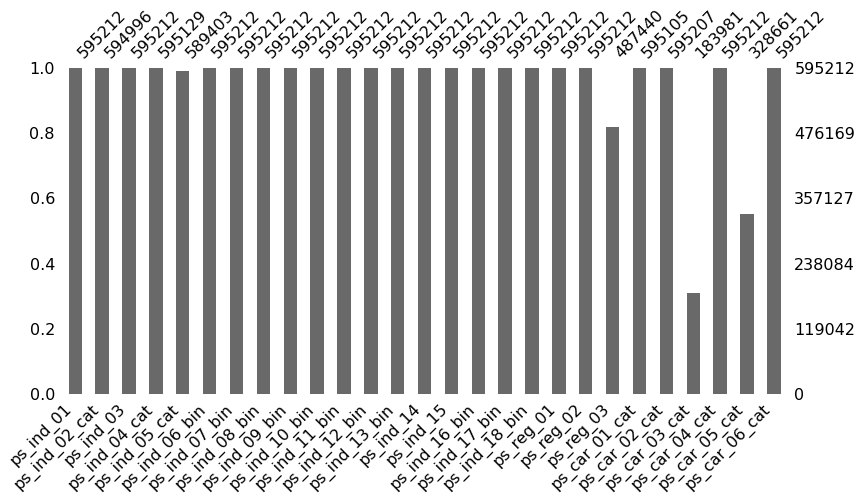

In [7]:
import numpy as np
import missingno as msno

# 훈련 데이터 복사본에서 -1을 np.NaN으로 변환
train_copy = train.copy().replace(-1, np.NaN)

# 결측값 시각화(피처 57개중 앞 28개 먼저)
msno.bar(df=train_copy.iloc[:, 1:28], figsize=(13, 6)) # missingno패키지의 bar()함수 : 결측값 막대그래프 시각화

 - 막대 그래프가 낲을수록 결측값이 많음
 - 그래프 상단에 정상값의 개수 표시

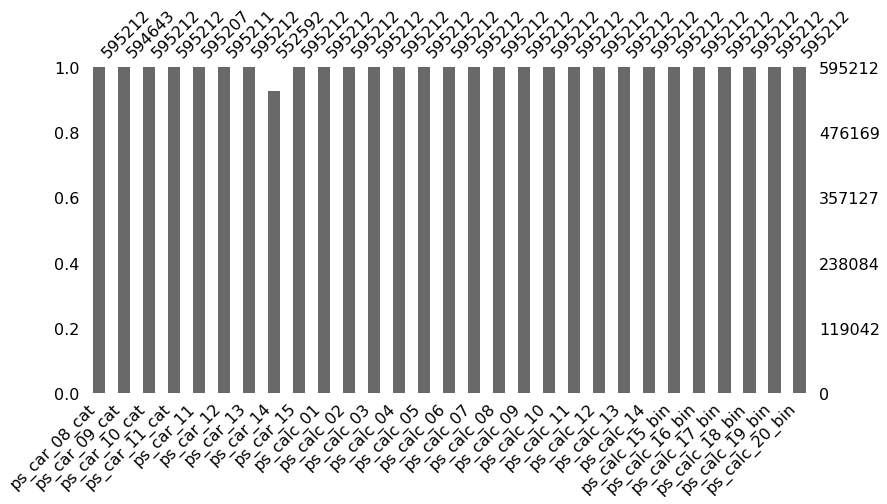

In [8]:
msno.bar(df=train_copy.iloc[:, 29:], figsize=(13, 6))

 - 결측값 매트릭스 형태로 시각화하기
  > bar() 대신 matrix() 함수 사용

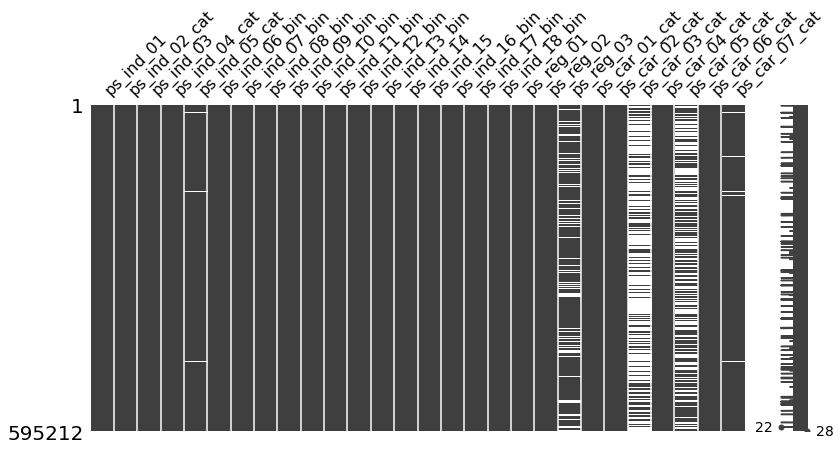

In [9]:
msno.matrix(df=train_copy.iloc[:, 1:29], figsize=(13, 6))

 - 22는 결측값이 없는 열 개수
 - 28은 전체 열 개수

#### 피처 요약표
 - 피처 종류가 다양해 한눈에 파악하기 위해 피처 요약표 만들자
 - 데이터 관리 및 그래프 그릴때 활용

In [17]:
def resumetable(df):
    print('데이터 형상 : {}'.format(df.shape))
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary['결측값 개수'] = (df== -1).sum().values # sum() : 데이터 프레임의 True만 '열'단위로 합산
    summary['고윳값 개수'] = df.nunique().values # nunique() : 데이터 프레임의 unique한 요소의 개수를 '열'단위로 합산
    summary['데이터 종류'] = None
    for col in df.columns:
        if 'bin' in col or col =='target':
            summary.loc[col, '데이터 종류'] = '이진형'
        elif 'cat' in col:
            summary.loc[col, '데이터 종류'] = '명목형'
        elif df[col].dtype == float: # 이진형/명목형도 아닌 데이터가 실수라면 연속형 데이터
            summary.loc[col, '데이터 종류'] = '연속형'
        elif df[col].dtype == int: # 이진형/명목형도 아닌 데이터가 정수라면 순서형 데이터
            summary.loc[col, '데이터 종류'] = '순서형'

    return summary

In [21]:
summary = resumetable(train) # 리턴되는 summary를 편하게 활용하기위해 변수에 넣음
summary

데이터 형상 : (595212, 58)


,데이터 타입,결측값 개수,고윳값 개수,데이터 종류
target,int64,0,2,이진형
ps_ind_01,int64,0,8,순서형
ps_ind_02_cat,int64,216,5,명목형
ps_ind_03,int64,0,12,순서형
ps_ind_04_cat,int64,83,3,명목형
ps_ind_05_cat,int64,5809,8,명목형
ps_ind_06_bin,int64,0,2,이진형
ps_ind_07_bin,int64,0,2,이진형
ps_ind_08_bin,int64,0,2,이진형
ps_ind_09_bin,int64,0,2,이진형


In [22]:
summary[summary['데이터 종류'] == '명목형']

,데이터 타입,결측값 개수,고윳값 개수,데이터 종류
ps_ind_02_cat,int64,216,5,명목형
ps_ind_04_cat,int64,83,3,명목형
ps_ind_05_cat,int64,5809,8,명목형
ps_car_01_cat,int64,107,13,명목형
ps_car_02_cat,int64,5,3,명목형
ps_car_03_cat,int64,411231,3,명목형
ps_car_04_cat,int64,0,10,명목형
ps_car_05_cat,int64,266551,3,명목형
ps_car_06_cat,int64,0,18,명목형
ps_car_07_cat,int64,11489,3,명목형


In [23]:
summary[summary['데이터 종류'] == '명목형'].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')

 - 피처 요약표를 통해 원하는 데이터 타입의 피처를 편하게 추출할 수 있다

### 데이터 시각화
 - 필요한 피처와 필요없는 피처 선별
 - 타깃값 분포를 활용해 타깃값이 얼마나 불균형 한지
 - 피처의 고윳값별 타깃값 비율을 알아보자
  > 모델링 시 어떤 피처를 제거해야할지 확인

#### 타깃값 분포

In [24]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Target Distribution')

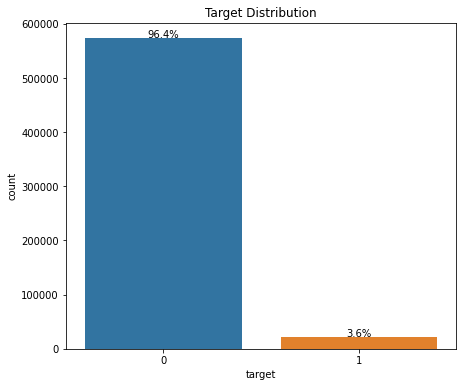

In [31]:
def write_percent(ax):
    total_size = 0
    for patch in ax.patches:
        total_size += patch.get_height()
    for patch in ax.patches:
        height = patch.get_height()
        width = patch.get_width()
        left_coord = patch.get_x()
        percent = height/total_size*100

        ax.text(x=left_coord + width/2.0,
                y=height + total_size*0.001,
                s=f'{percent:1.1f}%', # 입력 텍스트
                ha='center') # 가운데 정렬

plt.figure(figsize=(7,6))

ax = sns.countplot(x='target', data=train)
write_percent(ax)
ax.set_title('Target Distribution')

 - 타깃값 0은 96.4%, 1은 3.6% 차지
 - 전체 운전자 중 3.6.%만 보험금 청구 → 타깃값 불균형